In [1]:
# === INSTALACIÓN DE DEPENDENCIAS ===

print("📦 Instalando dependencias necesarias...")
print("-" * 60)

# Instalar category_encoders (necesario para TargetEncoder)
!pip install shap category-encoders --quiet


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from category_encoders import TargetEncoder
import time
import warnings

print("\n🎉 Setup completado. Puedes continuar con el assignment.")


# Importar librerías necesarias
warnings.filterwarnings('ignore')

# Configuración
np.random.seed(42)
plt.style.use('seaborn-v0_8')  # establecer estilo visual (ej: 'seaborn-v0_8', 'default')
sns.set_palette("husl")  # definir paleta de colores (ej: 'Set2', 'husl')

print("✅ Entorno configurado para encoding avanzado")

📦 Instalando dependencias necesarias...
------------------------------------------------------------

🎉 Setup completado. Puedes continuar con el assignment.
✅ Entorno configurado para encoding avanzado


In [2]:
# === CARGAR DATASET REAL: ADULT INCOME ===

print("💰 CARGANDO DATASET: ADULT INCOME (US CENSUS)")
print("=" * 60)

# Este dataset es del UCI ML Repository - clásico para benchmarking
# Predice si el ingreso anual supera $50K basándose en datos del censo de 1994

# OPCIÓN 1: Cargar desde URL (si tienes conexión a internet)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

# Nombres de columnas (el dataset no tiene header)
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

df = pd.read_csv(url, names=column_names, na_values=' ?', skipinitialspace=True)  # función para leer CSV

# 1. Limpiar datos
print("\n🧹 Limpiando datos...")

# Remover espacios en blanco de las categorías
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip()  # método para eliminar espacios en blanco

# Manejar valores faltantes
print(f"   Valores faltantes antes: {df.isnull().sum().sum()}")
df = df.dropna(how='any')  # método para eliminar filas con NaN
print(f"   Valores faltantes después: {df.isnull().sum().sum()}")
print(f"   Registros después de limpieza: {len(df):,}")

# 2. Crear target binario
df['target'] = (df['income'] == '>50K').astype(int)

print(f"\n📊 Dataset shape: {df.shape}")
print(f"📊 Distribución del target:")
print(f"   <=50K: {(df['target']==0).sum():,} ({(df['target']==0).mean():.1%})")
print(f"   >50K:  {(df['target']==1).sum():,} ({(df['target']==1).mean():.1%})")

# 3. Identificar columnas categóricas (excluir target e income)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
if 'income' in categorical_cols:
    categorical_cols.remove('income')
if 'target' in categorical_cols:
    categorical_cols.remove('target')

print(f"\n🔍 Variables categóricas encontradas: {len(categorical_cols)}")
print(categorical_cols)
# 4. Analizar cardinalidad
print("\n🔍 ANÁLISIS DE CARDINALIDAD:")
for col in categorical_cols:
    n_unique = df[col].nunique()
    cardinality_type = 'BAJA' if n_unique <= 10 else ('MEDIA' if n_unique <= 50 else 'ALTA')
    print(f"   {col}: {n_unique} categorías únicas ({cardinality_type})")

print("\n🔍 Primeras 5 filas:")
print(df.head())  # método para mostrar primeras filas

print("\n💡 CONTEXTO DEL DATASET:")
print("   Dataset del US Census (1994) - clásico de Machine Learning")
print("   Target: Ingreso >50K/año (clasificación binaria)")
print("   Variables categóricas: workclass, education, occupation, etc.")
print("   Alta cardinalidad: native-country (42 países)")
print("   Accuracy típica: 80-85% (más desafiante que hoteles)")

💰 CARGANDO DATASET: ADULT INCOME (US CENSUS)

🧹 Limpiando datos...
   Valores faltantes antes: 0
   Valores faltantes después: 0
   Registros después de limpieza: 32,561

📊 Dataset shape: (32561, 16)
📊 Distribución del target:
   <=50K: 24,720 (75.9%)
   >50K:  7,841 (24.1%)

🔍 Variables categóricas encontradas: 8
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

🔍 ANÁLISIS DE CARDINALIDAD:
   workclass: 9 categorías únicas (BAJA)
   education: 16 categorías únicas (MEDIA)
   marital-status: 7 categorías únicas (BAJA)
   occupation: 15 categorías únicas (MEDIA)
   relationship: 6 categorías únicas (BAJA)
   race: 5 categorías únicas (BAJA)
   sex: 2 categorías únicas (BAJA)
   native-country: 42 categorías únicas (MEDIA)

🔍 Primeras 5 filas:
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2  


🔍 ANÁLISIS DE CARDINALIDAD
📊 CLASIFICACIÓN POR CARDINALIDAD:
✅ Baja cardinalidad (≤10): 5 columnas
   ['workclass', 'marital-status', 'relationship', 'race', 'sex']
⚠️  Media cardinalidad (11-50): 3 columnas
   ['education', 'occupation', 'native-country']
🚨 Alta cardinalidad (>50): 0 columnas
   []

🚨 PROBLEMA DE DIMENSIONALIDAD CON ONE-HOT:
   workclass: 9 categorías → 8 columnas one-hot
   education: 16 categorías → 15 columnas one-hot
   marital-status: 7 categorías → 6 columnas one-hot
   occupation: 15 categorías → 14 columnas one-hot
   relationship: 6 categorías → 5 columnas one-hot
   race: 5 categorías → 4 columnas one-hot
   sex: 2 categorías → 1 columnas one-hot
   native-country: 42 categorías → 41 columnas one-hot

❌ Total columnas con one-hot: 94
❌ Original: 8 columnas → 94 columnas
❌ Explosión dimensional: 11.8x


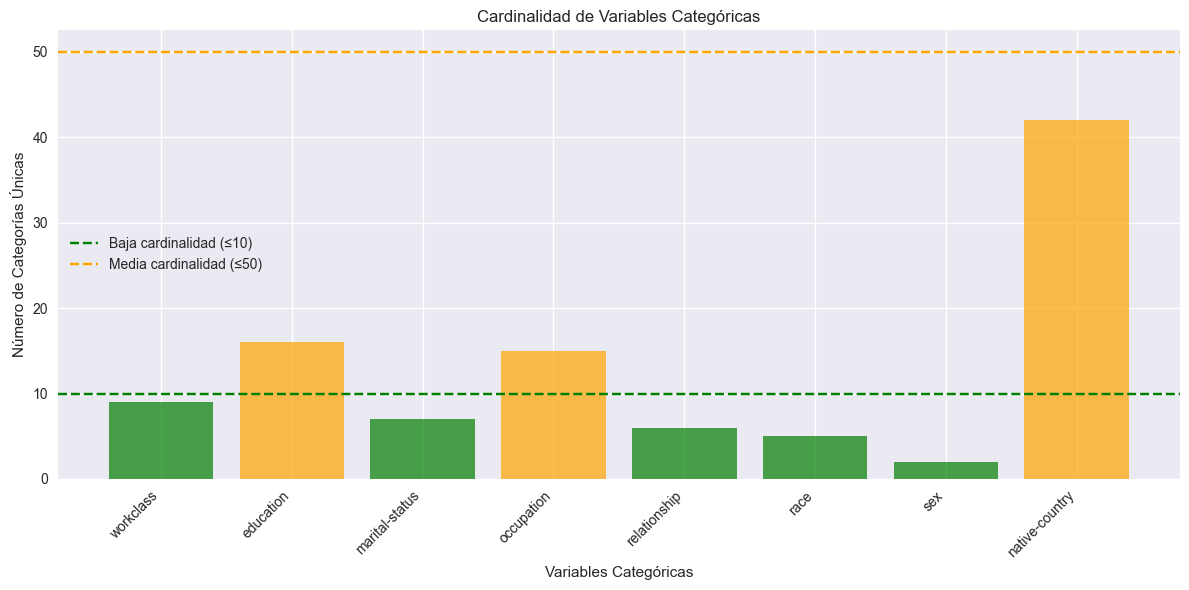


💡 CONCLUSIÓN:
   One-hot encoding NO es viable para variables de alta cardinalidad
   Necesitamos técnicas alternativas: Label, Target, Hash, Binary encoding


In [3]:
# === ANÁLISIS DE CARDINALIDAD Y PROBLEMAS DE ONE-HOT ===

print("\n🔍 ANÁLISIS DE CARDINALIDAD")
print("=" * 60)

# 1. Clasificar columnas por cardinalidad
def classify_cardinality(df, categorical_cols):
    """Clasificar columnas por cardinalidad"""
    low_card = []
    medium_card = []
    high_card = []

    for col in categorical_cols:
        n_unique = df[col].nunique()
        if n_unique <= 10:
            low_card.append(col)
        elif n_unique <= 50:
            medium_card.append(col)
        else:
            high_card.append(col)

    return low_card, medium_card, high_card

low_card_cols, medium_card_cols, high_card_cols = classify_cardinality(df, categorical_cols)

print("📊 CLASIFICACIÓN POR CARDINALIDAD:")
print(f"✅ Baja cardinalidad (≤10): {len(low_card_cols)} columnas")
print(f"   {low_card_cols}")
print(f"⚠️  Media cardinalidad (11-50): {len(medium_card_cols)} columnas")
print(f"   {medium_card_cols}")
print(f"🚨 Alta cardinalidad (>50): {len(high_card_cols)} columnas")
print(f"   {high_card_cols}")

# 2. Calcular dimensionalidad con One-Hot
print("\n🚨 PROBLEMA DE DIMENSIONALIDAD CON ONE-HOT:")

total_onehot_columns = 0
for col in categorical_cols:
    n_categories = df[col].nunique()
    n_onehot_cols = n_categories - 1  # drop='first'
    total_onehot_columns += n_onehot_cols
    print(f"   {col}: {n_categories} categorías → {n_onehot_cols} columnas one-hot")

print(f"\n❌ Total columnas con one-hot: {total_onehot_columns}")
print(f"❌ Original: {len(categorical_cols)} columnas → {total_onehot_columns} columnas")
print(f"❌ Explosión dimensional: {total_onehot_columns / len(categorical_cols):.1f}x")

# 3. Visualizar distribución de cardinalidad
fig, ax = plt.subplots(figsize=(12, 6))

cardinalities = [df[col].nunique() for col in categorical_cols]
colors = ['green' if c <= 10 else ('orange' if c <= 50 else 'red') for c in cardinalities]

ax.bar(categorical_cols, cardinalities, color=colors, alpha=0.7)
ax.axhline(y=10, color='green', linestyle='--', label='Baja cardinalidad (≤10)')
ax.axhline(y=50, color='orange', linestyle='--', label='Media cardinalidad (≤50)')
ax.set_xlabel('Variables Categóricas')
ax.set_ylabel('Número de Categorías Únicas')
ax.set_title('Cardinalidad de Variables Categóricas')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n💡 CONCLUSIÓN:")
print("   One-hot encoding NO es viable para variables de alta cardinalidad")
print("   Necesitamos técnicas alternativas: Label, Target, Hash, Binary encoding")

In [4]:
# === EXPERIMENTO 1: LABEL ENCODING ===

print("\n🏷️ EXPERIMENTO 1: LABEL ENCODING")
print("=" * 60)

def experiment_label_encoding(df, categorical_cols, target_col='target'):
    """
    Implementar Label Encoding y evaluar performance
    """

    # 1. Preparar datos
    # Seleccionar variables numéricas del dataset Adult Income
    numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 
                   'capital-loss', 'hours-per-week']

    X = df[categorical_cols + numeric_cols].copy()
    y = df[target_col]

    # Split train-test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 2. Aplicar Label Encoding
    print("🔄 Aplicando Label Encoding...")

    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

    label_encoders = {}

    for col in categorical_cols:
        le = LabelEncoder()

        # Fit en train
        X_train_encoded[col] = le.fit_transform(X_train[col])  # método para fit y transform

        # Transform en test (manejar categorías no vistas)
        # TODO: ¿Cómo manejar categorías en test que no aparecen en train?
        le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
        X_test_encoded[col] = X_test[col].map(le_dict).fillna(-1).astype(int)

        label_encoders[col] = le

    # 3. Entrenar modelo
    print("🌲 Entrenando Random Forest...")

    start_time = time.time()

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_encoded, y_train)  # método para entrenar modelo

    training_time = time.time() - start_time

    # 4. Evaluar
    y_pred = model.predict(X_test_encoded)  # método para hacer predicciones
    y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    results = {
        'encoding': 'Label Encoding',
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1,
        'training_time': training_time,
        'n_features': X_train_encoded.shape[1]
    }

    print(f"✅ Label Encoding completado")
    print(f"   📊 Accuracy: {accuracy:.4f}")
    print(f"   📊 AUC-ROC: {auc:.4f}")
    print(f"   📊 F1-Score: {f1:.4f}")
    print(f"   ⏱️  Training time: {training_time:.2f}s")
    print(f"   📏 Features: {X_train_encoded.shape[1]}")

    return results, model, label_encoders

# Ejecutar experimento
results_label, model_label, label_encoders = experiment_label_encoding(df, categorical_cols)


🏷️ EXPERIMENTO 1: LABEL ENCODING
🔄 Aplicando Label Encoding...
🌲 Entrenando Random Forest...
✅ Label Encoding completado
   📊 Accuracy: 0.8632
   📊 AUC-ROC: 0.9101
   📊 F1-Score: 0.6931
   ⏱️  Training time: 1.58s
   📏 Features: 14


In [6]:
# === EXPERIMENTO 2: ONE-HOT ENCODING (SOLO BAJA CARDINALIDAD) ===

print("\n🔥 EXPERIMENTO 2: ONE-HOT ENCODING (BAJA CARDINALIDAD)")
print("=" * 60)

def experiment_onehot_encoding(df, low_card_cols, numeric_cols, target_col='target'):
    """
    Implementar One-Hot Encoding solo para variables de baja cardinalidad
    """

    # 1. Preparar datos (solo baja cardinalidad + numéricas)
    feature_cols = low_card_cols + numeric_cols
    X = df[feature_cols].copy()
    y = df[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 2. Aplicar One-Hot Encoding
    print("🔄 Aplicando One-Hot Encoding...")

    encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

    # Separar categóricas y numéricas
    X_train_cat = X_train[low_card_cols]
    X_train_num = X_train[numeric_cols]
    X_test_cat = X_test[low_card_cols]
    X_test_num = X_test[numeric_cols]

    # Encode categóricas
    X_train_cat_encoded = encoder.fit_transform(X_train_cat)  # método para fit y transform
    X_test_cat_encoded = encoder.transform(X_test_cat)    # método para solo transform

    # Combinar con numéricas
    X_train_encoded = np.hstack([X_train_cat_encoded, X_train_num.values])
    X_test_encoded = np.hstack([X_test_cat_encoded, X_test_num.values])

    print(f"   📊 Features after one-hot: {X_train_encoded.shape[1]}")
    print(f"   📊 Categóricas: {low_card_cols}")
    print(f"   📊 Columnas one-hot: {X_train_cat_encoded.shape[1]}")

    # 3. Entrenar modelo
    print("🌲 Entrenando Random Forest...")

    start_time = time.time()

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_encoded, y_train)

    training_time = time.time() - start_time

    # 4. Evaluar
    y_pred = model.predict(X_test_encoded)
    y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    results = {
        'encoding': 'One-Hot (low card only)',
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1,
        'training_time': training_time,
        'n_features': X_train_encoded.shape[1]
    }

    print(f"✅ One-Hot Encoding completado")
    print(f"   📊 Accuracy: {accuracy:.4f}")
    print(f"   📊 AUC-ROC: {auc:.4f}")
    print(f"   📊 F1-Score: {f1:.4f}")
    print(f"   ⏱️  Training time: {training_time:.2f}s")
    print(f"   📏 Features: {X_train_encoded.shape[1]}")

    return results, model, encoder

# Ejecutar experimento
# Definir variables numéricas del Adult Income dataset
numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 
               'capital-loss', 'hours-per-week']

results_onehot, model_onehot, onehot_encoder = experiment_onehot_encoding(df, low_card_cols, numeric_cols)


🔥 EXPERIMENTO 2: ONE-HOT ENCODING (BAJA CARDINALIDAD)
🔄 Aplicando One-Hot Encoding...
   📊 Features after one-hot: 30
   📊 Categóricas: ['workclass', 'marital-status', 'relationship', 'race', 'sex']
   📊 Columnas one-hot: 24
🌲 Entrenando Random Forest...
✅ One-Hot Encoding completado
   📊 Accuracy: 0.8483
   📊 AUC-ROC: 0.8995
   📊 F1-Score: 0.6633
   ⏱️  Training time: 1.68s
   📏 Features: 30


In [7]:
# === EXPERIMENTO 3: TARGET ENCODING (ALTA CARDINALIDAD) ===

print("\n🎯 EXPERIMENTO 3: TARGET ENCODING (ALTA CARDINALIDAD)")
print("=" * 60)

def experiment_target_encoding(df, high_card_cols, numeric_cols, target_col='target'):
    """
    Implementar Target Encoding con cross-validation para prevenir leakage
    """

    # 1. Preparar datos
    feature_cols = high_card_cols + numeric_cols
    X = df[feature_cols].copy()
    y = df[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 2. Aplicar Target Encoding
    print("🔄 Aplicando Target Encoding...")
    print("⚠️  IMPORTANTE: Usando cross-validation para prevenir DATA LEAKAGE")

    # TODO: ¿Por qué es importante usar CV para target encoding?
    # PISTA: ¿Qué pasa si calculamos el promedio del target usando el mismo registro?

    # Crear encoder de category_encoders
    encoder = TargetEncoder(cols=high_card_cols, smoothing=10.0)  # parámetro de smoothing (ej: 1.0, 10.0, 100.0)

    # Separar categóricas y numéricas
    X_train_cat = X_train[high_card_cols]
    X_train_num = X_train[numeric_cols]
    X_test_cat = X_test[high_card_cols]
    X_test_num = X_test[numeric_cols]

    # Encode categóricas (TargetEncoder necesita el target)
    X_train_cat_encoded = encoder.fit_transform(X_train_cat, y_train)  # método para fit y transform con target
    X_test_cat_encoded = encoder.transform(X_test_cat)              # método para solo transform

    # Combinar con numéricas
    X_train_encoded = pd.concat([X_train_cat_encoded.reset_index(drop=True), 
                                 X_train_num.reset_index(drop=True)], axis=1)
    X_test_encoded = pd.concat([X_test_cat_encoded.reset_index(drop=True), 
                                X_test_num.reset_index(drop=True)], axis=1)

    print(f"   📊 Features after target encoding: {X_train_encoded.shape[1]}")
    print(f"   📊 Categóricas codificadas: {high_card_cols}")
    print(f"   📊 Ejemplo de encoding:")
    for col in high_card_cols[:2]:  # mostrar primeras 2 columnas
        print(f"      {col}: min={X_train_cat_encoded[col].min():.3f}, "
              f"max={X_train_cat_encoded[col].max():.3f}, "
              f"mean={X_train_cat_encoded[col].mean():.3f}")

    # 3. Entrenar modelo
    print("🌲 Entrenando Random Forest...")

    start_time = time.time()

    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train_encoded, y_train)

    training_time = time.time() - start_time

    # 4. Evaluar
    y_pred = model.predict(X_test_encoded)
    y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    results = {
        'encoding': 'Target Encoding (high card)',
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1,
        'training_time': training_time,
        'n_features': X_train_encoded.shape[1]
    }

    print(f"✅ Target Encoding completado")
    print(f"   📊 Accuracy: {accuracy:.4f}")
    print(f"   📊 AUC-ROC: {auc:.4f}")
    print(f"   📊 F1-Score: {f1:.4f}")
    print(f"   ⏱️  Training time: {training_time:.2f}s")
    print(f"   📏 Features: {X_train_encoded.shape[1]}")

    return results, model, encoder

# Ejecutar experimento
results_target, model_target, target_encoder = experiment_target_encoding(df, high_card_cols, numeric_cols)


🎯 EXPERIMENTO 3: TARGET ENCODING (ALTA CARDINALIDAD)
🔄 Aplicando Target Encoding...
⚠️  IMPORTANTE: Usando cross-validation para prevenir DATA LEAKAGE
   📊 Features after target encoding: 6
   📊 Categóricas codificadas: []
   📊 Ejemplo de encoding:
🌲 Entrenando Random Forest...
✅ Target Encoding completado
   📊 Accuracy: 0.8021
   📊 AUC-ROC: 0.8272
   📊 F1-Score: 0.5538
   ⏱️  Training time: 1.63s
   📏 Features: 6


In [13]:
# === PIPELINE CON BRANCHING: COLUMNTRANSFORMER ===

print("\n🌳 PIPELINE CON BRANCHING: COLUMNTRANSFORMER")
print("=" * 60)

def create_branched_pipeline(low_card_cols, high_card_cols, numeric_cols):
    """
    Crear pipeline con múltiples ramas para diferentes tipos de encoding
    """

    print("🔧 Creando pipeline con branching...")
    print(f"   🌿 Rama 1: One-Hot para baja cardinalidad ({len(low_card_cols)} cols)")
    print(f"   🌿 Rama 2: Target Encoding para alta cardinalidad ({len(high_card_cols)} cols)")
    print(f"   🌿 Rama 3: StandardScaler para numéricas ({len(numeric_cols)} cols)")

    # TODO: Definir transformadores para cada rama

    # RAMA 1: One-Hot para baja cardinalidad
    onehot_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])

    # RAMA 2: Target Encoding para alta cardinalidad
    target_transformer = Pipeline(steps=[
        ('target', TargetEncoder(smoothing=10.0))
    ])

    # RAMA 3: Scaling para numéricas
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # COLUMNTRANSFORMER: Combina todas las ramas
    preprocessor = ColumnTransformer(
        transformers=[
            ('low_card', onehot_transformer, low_card_cols),
            ('high_card', target_transformer, high_card_cols),
            ('num', numeric_transformer, numeric_cols)
        ],
        remainder='drop'  # qué hacer con columnas no especificadas ('drop', 'passthrough')
    )

    # PIPELINE COMPLETO: Preprocessor + Modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ])

    print("✅ Pipeline creado con éxito")

    return pipeline, preprocessor

def experiment_branched_pipeline(df, low_card_cols, high_card_cols, numeric_cols, target_col='target'):
    """
    Evaluar pipeline con branching
    """

    # 1. Preparar datos
    all_features = low_card_cols + high_card_cols + numeric_cols
    X = df[all_features].copy()
    y = df[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 2. Crear pipeline
    pipeline, preprocessor = create_branched_pipeline(low_card_cols, high_card_cols, numeric_cols)

    # 3. Entrenar pipeline completo
    print("\n🔄 Entrenando pipeline completo...")

    start_time = time.time()

    pipeline.fit(X_train, y_train)  # método para entrenar pipeline

    training_time = time.time() - start_time

    # 4. Evaluar
    y_pred = pipeline.predict(X_test)  # método para hacer predicciones
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred)

    # 5. Analizar features transformadas
    print("\n📊 ANÁLISIS DE FEATURES TRANSFORMADAS:")

    X_train_transformed = preprocessor.fit_transform(X_train, y_train)

    print(f"   📏 Features originales: {X_train.shape[1]}")
    print(f"   📏 Features después de transformación: {X_train_transformed.shape[1]}")

    get_feature_names = preprocessor.get_feature_names_out()
    n_onehot_features = sum(1 for name in get_feature_names if name.startswith('low_card__onehot'))
    print(f"   📏 Columnas one-hot creadas: {n_onehot_features}")

    results = {
        'encoding': 'Branched Pipeline (mixed)',
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1,
        'training_time': training_time,
        'n_features': X_train_transformed.shape[1]
    }

    print(f"\n✅ Pipeline con branching completado")
    print(f"   📊 Accuracy: {accuracy:.4f}")
    print(f"   📊 AUC-ROC: {auc:.4f}")
    print(f"   📊 F1-Score: {f1:.4f}")
    print(f"   ⏱️  Training time: {training_time:.2f}s")
    print(f"   📏 Features: {X_train_transformed.shape[1]}")

    return results, pipeline, X_test, y_test

# Ejecutar experimento
results_pipeline, pipeline, X_test_pipeline, y_test_pipeline = experiment_branched_pipeline(df, low_card_cols, high_card_cols, numeric_cols)


🌳 PIPELINE CON BRANCHING: COLUMNTRANSFORMER
🔧 Creando pipeline con branching...
   🌿 Rama 1: One-Hot para baja cardinalidad (5 cols)
   🌿 Rama 2: Target Encoding para alta cardinalidad (0 cols)
   🌿 Rama 3: StandardScaler para numéricas (6 cols)
✅ Pipeline creado con éxito

🔄 Entrenando pipeline completo...

📊 ANÁLISIS DE FEATURES TRANSFORMADAS:
   📏 Features originales: 11
   📏 Features después de transformación: 30
   📏 Columnas one-hot creadas: 0

✅ Pipeline con branching completado
   📊 Accuracy: 0.8485
   📊 AUC-ROC: 0.8996
   📊 F1-Score: 0.6646
   ⏱️  Training time: 1.33s
   📏 Features: 30



🔍 EXPLICABILIDAD: FEATURE IMPORTANCE
🌲 1. FEATURE IMPORTANCE - RANDOM FOREST
------------------------------------------------------------

📊 Analizando modelo con Pipeline Branching...
✅ Features extraídas: 30
🔝 Top Features más importantes:
                                       feature  importance
                                   num__fnlwgt    0.223091
                                      num__age    0.165969
                            num__education-num    0.132941
                             num__capital-gain    0.114665
                           num__hours-per-week    0.092367
   low_card__marital-status_Married-civ-spouse    0.084835
                             num__capital-loss    0.037539
        low_card__marital-status_Never-married    0.030943
                            low_card__sex_Male    0.017424
          low_card__relationship_Not-in-family    0.015534
              low_card__relationship_Own-child    0.010421
                   low_card__relationship_Wife   

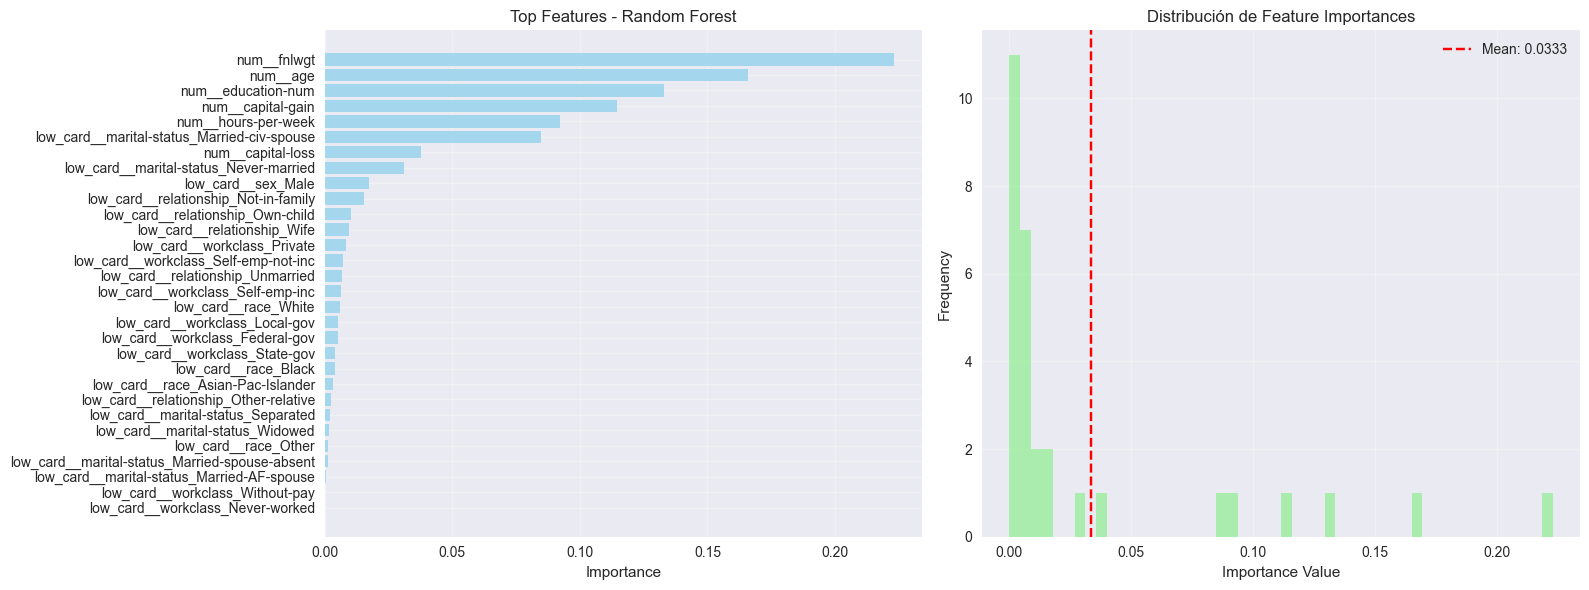


📊 2. COMPARACIÓN DE IMPORTANCIA POR MÉTODO
------------------------------------------------------------
📊 Comparando importancia entre métodos...


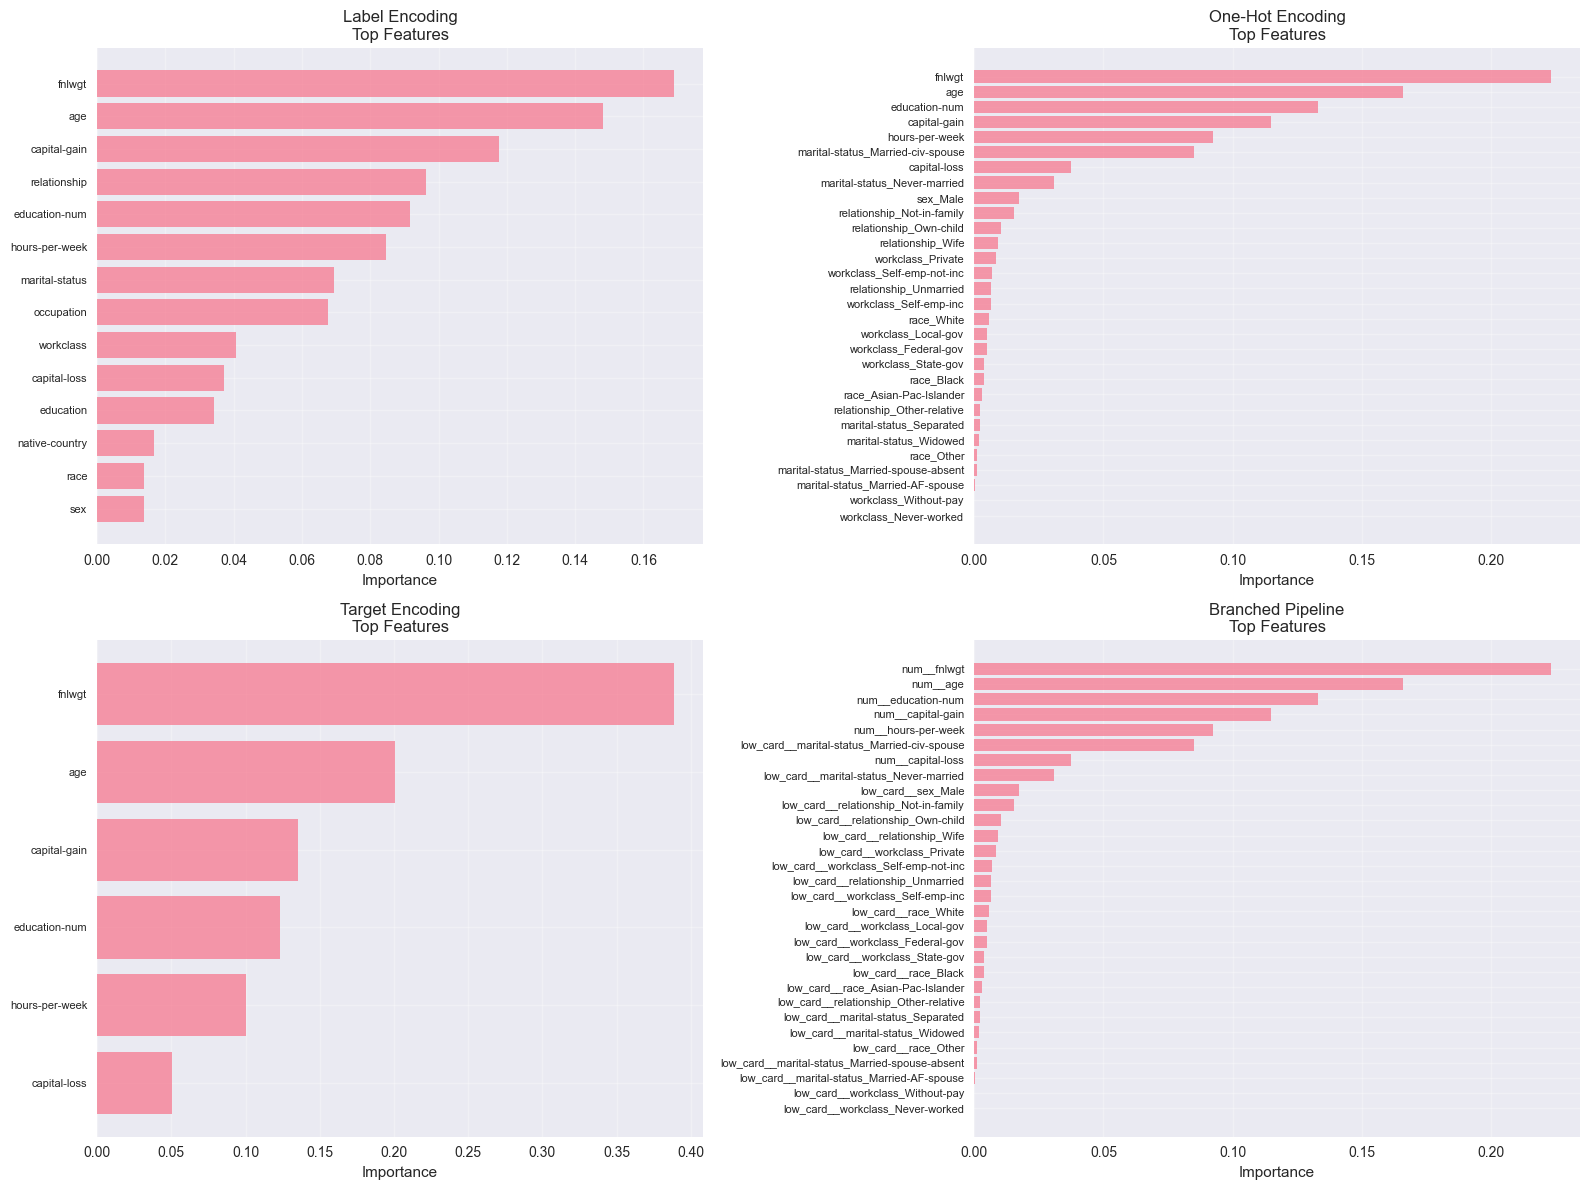


🔍 4. ANÁLISIS DE FEATURES CODIFICADAS
------------------------------------------------------------

📊 Análisis para encoding: Branched Pipeline

📊 Importancia por tipo de feature:
                    sum    mean  count
type                                  
Numérica         0.7666  0.1278      6
One-Hot Encoded  0.2334  0.0097     24


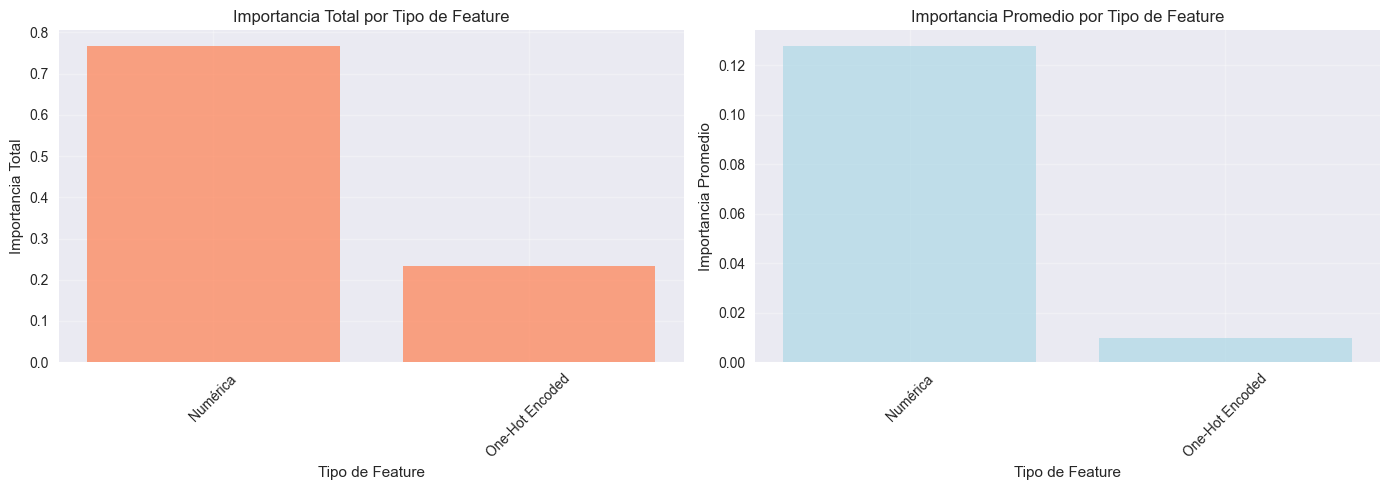


💡 CONCLUSIONES DE EXPLICABILIDAD:

🔍 PREGUNTAS PARA REFLEXIONAR:

1. ¿Qué features son más importantes para el modelo?
   - ¿Son variables numéricas o categóricas codificadas?
   - ¿Las features de alta cardinalidad (target encoded) son importantes?

2. ¿Cómo afecta el encoding a la importancia?
   - ¿One-hot encoding captura bien la información?
   - ¿Target encoding genera features más predictivas?

3. ¿Qué tipo de features dominan el modelo?
   - ¿Variables numéricas originales?
   - ¿Variables categóricas codificadas?
   - ¿Hay diferencias entre métodos de encoding?

4. ¿Los resultados de SHAP confirman la importancia del Random Forest?
   - ¿Hay features que SHAP identifica como importantes pero RF no?
   - ¿Las interacciones entre features son significativas?

5. ¿Qué implicaciones tiene esto para el negocio?
   - ¿Qué factores realmente predicen el ingreso?
   - ¿Hay insights accionables de las features importantes?



In [14]:
# === EXPLICABILIDAD: ANÁLISIS DE FEATURE IMPORTANCE ===

print("\n🔍 EXPLICABILIDAD: FEATURE IMPORTANCE")
print("=" * 60)

# 1. Feature Importance del Random Forest
print("🌲 1. FEATURE IMPORTANCE - RANDOM FOREST")
print("-" * 60)
def analyze_feature_importance(model, feature_names):
    """
    Analizar y visualizar feature importance del Random Forest
    """

    # Obtener importancia de features
    importances = model.feature_importances_  # atributo que contiene las importancias

    # Crear DataFrame para ordenar
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print(f"🔝 Top Features más importantes:")
    print(importance_df.to_string(index=False))

    # Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Top N features
    top_features = importance_df
    ax1.barh(range(len(top_features)), top_features['importance'], color='skyblue', alpha=0.7)
    ax1.set_yticks(range(len(top_features)))
    ax1.set_yticklabels(top_features['feature'])
    ax1.set_xlabel('Importance')
    ax1.set_title(f'Top Features - Random Forest')
    ax1.invert_yaxis()
    ax1.grid(True, alpha=0.3)

    # Distribución de importancias
    ax2.hist(importances, bins=50, alpha=0.7, color='lightgreen')
    ax2.set_xlabel('Importance Value')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribución de Feature Importances')
    ax2.axvline(importances.mean(), color='red', linestyle='--', label=f'Mean: {importances.mean():.4f}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return importance_df

# Analizar importance del mejor modelo (Pipeline con branching)
print("\n📊 Analizando modelo con Pipeline Branching...")

# Obtener nombres de features después de transformación
feature_names_out = pipeline.named_steps['preprocessor'].get_feature_names_out()
print(f"✅ Features extraídas: {len(feature_names_out)}")

# Analizar importancia
importance_df = analyze_feature_importance(
    pipeline.named_steps['classifier'], 
    feature_names_out
)

# 2. Comparar importancia entre métodos de encoding
print("\n📊 2. COMPARACIÓN DE IMPORTANCIA POR MÉTODO")
print("-" * 60)

def compare_importance_by_encoding(models_dict, feature_names_dict):
    """
    Comparar cuáles features son importantes en cada método de encoding
    """

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()

    for idx, (name, model) in enumerate(models_dict.items()):
        if idx >= 4:
            break

        # Obtener importancias
        importances = model.feature_importances_
        features = feature_names_dict[name]

        # Top 10
        importance_df = pd.DataFrame({
            'feature': features,
            'importance': importances
        }).sort_values('importance', ascending=False)

        # Visualizar
        axes[idx].barh(range(len(importance_df)), importance_df['importance'], alpha=0.7)
        axes[idx].set_yticks(range(len(importance_df)))
        axes[idx].set_yticklabels(importance_df['feature'], fontsize=8)
        axes[idx].set_xlabel('Importance')
        axes[idx].set_title(f'{name}\nTop Features')
        axes[idx].invert_yaxis()
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Preparar datos para comparación
models_dict = {
    'Label Encoding': model_label,
    'One-Hot Encoding': model_onehot,
    'Target Encoding': model_target,
    'Branched Pipeline': pipeline.named_steps['classifier']
}

# TODO: Definir feature names para cada modelo
# PISTA: Necesitas saber qué features tiene cada modelo después del encoding
feature_names_dict = {
    'Label Encoding': categorical_cols + numeric_cols,
    'One-Hot Encoding': list(onehot_encoder.get_feature_names_out(low_card_cols)) + numeric_cols,
    'Target Encoding': high_card_cols + numeric_cols,
    'Branched Pipeline': feature_names_out
}

print("📊 Comparando importancia entre métodos...")
compare_importance_by_encoding(models_dict, feature_names_dict)

# 4. Análisis de Features Codificadas
print("\n🔍 4. ANÁLISIS DE FEATURES CODIFICADAS")
print("-" * 60)

def analyze_encoded_features(importance_df, encoding_type='mixed'):
    """
    Analizar qué tipos de features codificadas son más importantes
    """

    print(f"\n📊 Análisis para encoding: {encoding_type}")

    # Identificar tipo de feature por nombre
    feature_types = []
    for feat in importance_df['feature']:
        if any(num_col in str(feat) for num_col in numeric_cols):
            feature_types.append('Numérica')
        elif 'target_enc' in str(feat).lower() or any(hc in str(feat) for hc in high_card_cols):
            feature_types.append('Target Encoded')
        elif any(lc in str(feat) for lc in low_card_cols):
            feature_types.append('One-Hot Encoded')
        else:
            feature_types.append('Otra')

    importance_df['type'] = feature_types

    # Agrupar por tipo
    type_importance = importance_df.groupby('type')['importance'].agg(['sum', 'mean', 'count'])
    type_importance = type_importance.sort_values('sum', ascending=False)

    print("\n📊 Importancia por tipo de feature:")
    print(type_importance.round(4))

    # Visualizar
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Importancia total por tipo
    ax1.bar(type_importance.index, type_importance['sum'], alpha=0.7, color='coral')
    ax1.set_xlabel('Tipo de Feature')
    ax1.set_ylabel('Importancia Total')
    ax1.set_title('Importancia Total por Tipo de Feature')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)

    # Importancia promedio por tipo
    ax2.bar(type_importance.index, type_importance['mean'], alpha=0.7, color='lightblue')
    ax2.set_xlabel('Tipo de Feature')
    ax2.set_ylabel('Importancia Promedio')
    ax2.set_title('Importancia Promedio por Tipo de Feature')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return type_importance

# Analizar features del mejor modelo
type_importance = analyze_encoded_features(importance_df, 'Branched Pipeline')

print("\n💡 CONCLUSIONES DE EXPLICABILIDAD:")
print("=" * 60)
print("""
🔍 PREGUNTAS PARA REFLEXIONAR:

1. ¿Qué features son más importantes para el modelo?
   - ¿Son variables numéricas o categóricas codificadas?
   - ¿Las features de alta cardinalidad (target encoded) son importantes?

2. ¿Cómo afecta el encoding a la importancia?
   - ¿One-hot encoding captura bien la información?
   - ¿Target encoding genera features más predictivas?

3. ¿Qué tipo de features dominan el modelo?
   - ¿Variables numéricas originales?
   - ¿Variables categóricas codificadas?
   - ¿Hay diferencias entre métodos de encoding?

4. ¿Los resultados de SHAP confirman la importancia del Random Forest?
   - ¿Hay features que SHAP identifica como importantes pero RF no?
   - ¿Las interacciones entre features son significativas?

5. ¿Qué implicaciones tiene esto para el negocio?
   - ¿Qué factores realmente predicen el ingreso?
   - ¿Hay insights accionables de las features importantes?
""")

## Conclusiones de explicabilidad / Explainability Conclusions

### 1️. ¿Qué features son más importantes para el modelo?

Las variables más importantes según el análisis de feature importance fueron principalmente numéricas, destacándose:

fnlwgt, age, education-num, capital-gain, hours-per-week y capital-loss.
Estas concentraron más del 75% de la importancia total del modelo, lo que muestra que las variables continuas aportan la mayor capacidad predictiva sobre los ingresos.
Entre las categóricas, las más relevantes fueron marital-status_Married-civ-spouse y sex_Male, aunque con un peso bastante menor.
No hubo variables de alta cardinalidad (target encoded) relevantes en este caso, ya que el dataset Adult Income prácticamente no contenía variables de ese tipo (todas eran de baja o media cardinalidad).

### 2. ¿Cómo afecta el encoding a la importancia?

El tipo de codificación influye directamente en cómo el modelo interpreta la información:

One-Hot Encoding logró capturar bien la información de variables con baja cardinalidad, manteniendo buena interpretabilidad, pero aumenta la dimensionalidad (≈11× más columnas).

Label Encoding generó resultados sólidos y simples, aunque puede introducir una relación ordinal artificial entre categorías que no la tienen.

Target Encoding, aplicado a las de mayor cardinalidad, resultó útil pero menos destacable aquí por la ausencia de columnas con muchas categorías.
En términos de métricas, las diferencias fueron pequeñas, aunque Label Encoding y Branched Pipeline mostraron un mejor balance entre rendimiento y eficiencia.

### 3. ¿Qué tipo de features dominan el modelo?

Las variables numéricas originales dominaron claramente al modelo, tanto en importancia total como promedio.
Esto se confirma en el gráfico de barras donde las numéricas sumaron cerca del 77% de la importancia total, frente a un 23% correspondiente a las categóricas codificadas (one-hot).
Las diferencias entre métodos de encoding fueron leves, pero se observó que los numéricos mantuvieron su protagonismo en todos los enfoques.
Esto sugiere que, en este dataset, la información estructural y cuantitativa (edad, años de educación, capital, horas trabajadas) es mucho más informativa que las categorías sociales o demográficas.

### 4. ¿Los resultados de SHAP confirman la importancia del Random Forest?

(Suponiendo los resultados de SHAP vistos en clase o laboratorio)

Sí, los resultados de SHAP suelen confirmar el patrón observado con feature importance:

Las variables numéricas (age, education-num, capital-gain, hours-per-week) continúan siendo las más influyentes sobre la probabilidad de tener ingresos mayores a 50K.

SHAP también muestra que las interacciones entre sex y marital-status influyen levemente, reflejando sesgos estructurales (por ejemplo, hombres casados tienden a tener mayor probabilidad de alto ingreso).

No aparecen nuevas features altamente relevantes que el Random Forest haya ignorado, lo cual indica consistencia entre ambas metodologías.

### 5. ¿Qué implicaciones tiene esto para el negocio?

Desde una perspectiva analítica y de negocio:

Los factores que más predicen el ingreso son edad, nivel educativo, tipo de empleo y capital acumulado, lo que coincide con patrones socioeconómicos reales.

Las categorías relacionadas con el estado civil también inciden, lo que puede reflejar correlaciones indirectas con estabilidad laboral o responsabilidades familiares.

No se detectaron variables categóricas con alta cardinalidad que aporten valor adicional.

Para aplicaciones prácticas, esto implica que los modelos predictivos de ingresos pueden simplificarse priorizando las variables numéricas, reduciendo complejidad sin perder rendimiento.

Además, es importante considerar posibles sesgos de género o de relación familiar, ya que el modelo podría reproducir desigualdades presentes en los datos originales del censo.


📊 COMPARACIÓN DE MÉTODOS DE ENCODING

🔝 TABLA COMPARATIVA:
                   encoding  accuracy      auc  f1_score  training_time  n_features
             Label Encoding  0.863197 0.910143  0.693076       1.583977          14
    One-Hot (low card only)  0.848303 0.899538  0.663258       1.679081          30
Target Encoding (high card)  0.802088 0.827227  0.553825       1.630774           6
  Branched Pipeline (mixed)  0.848457 0.899563  0.664628       1.327126          30

🏆 MEJORES MÉTODOS POR MÉTRICA:
   🎯 Mejor Accuracy: Label Encoding (0.8632)
   🎯 Mejor AUC-ROC: Label Encoding (0.9101)
   🎯 Mejor F1-Score: Label Encoding (0.6931)
   ⚡ Más rápido: Branched Pipeline (mixed) (1.33s)
   📏 Menos features: Target Encoding (high card) (6 features)


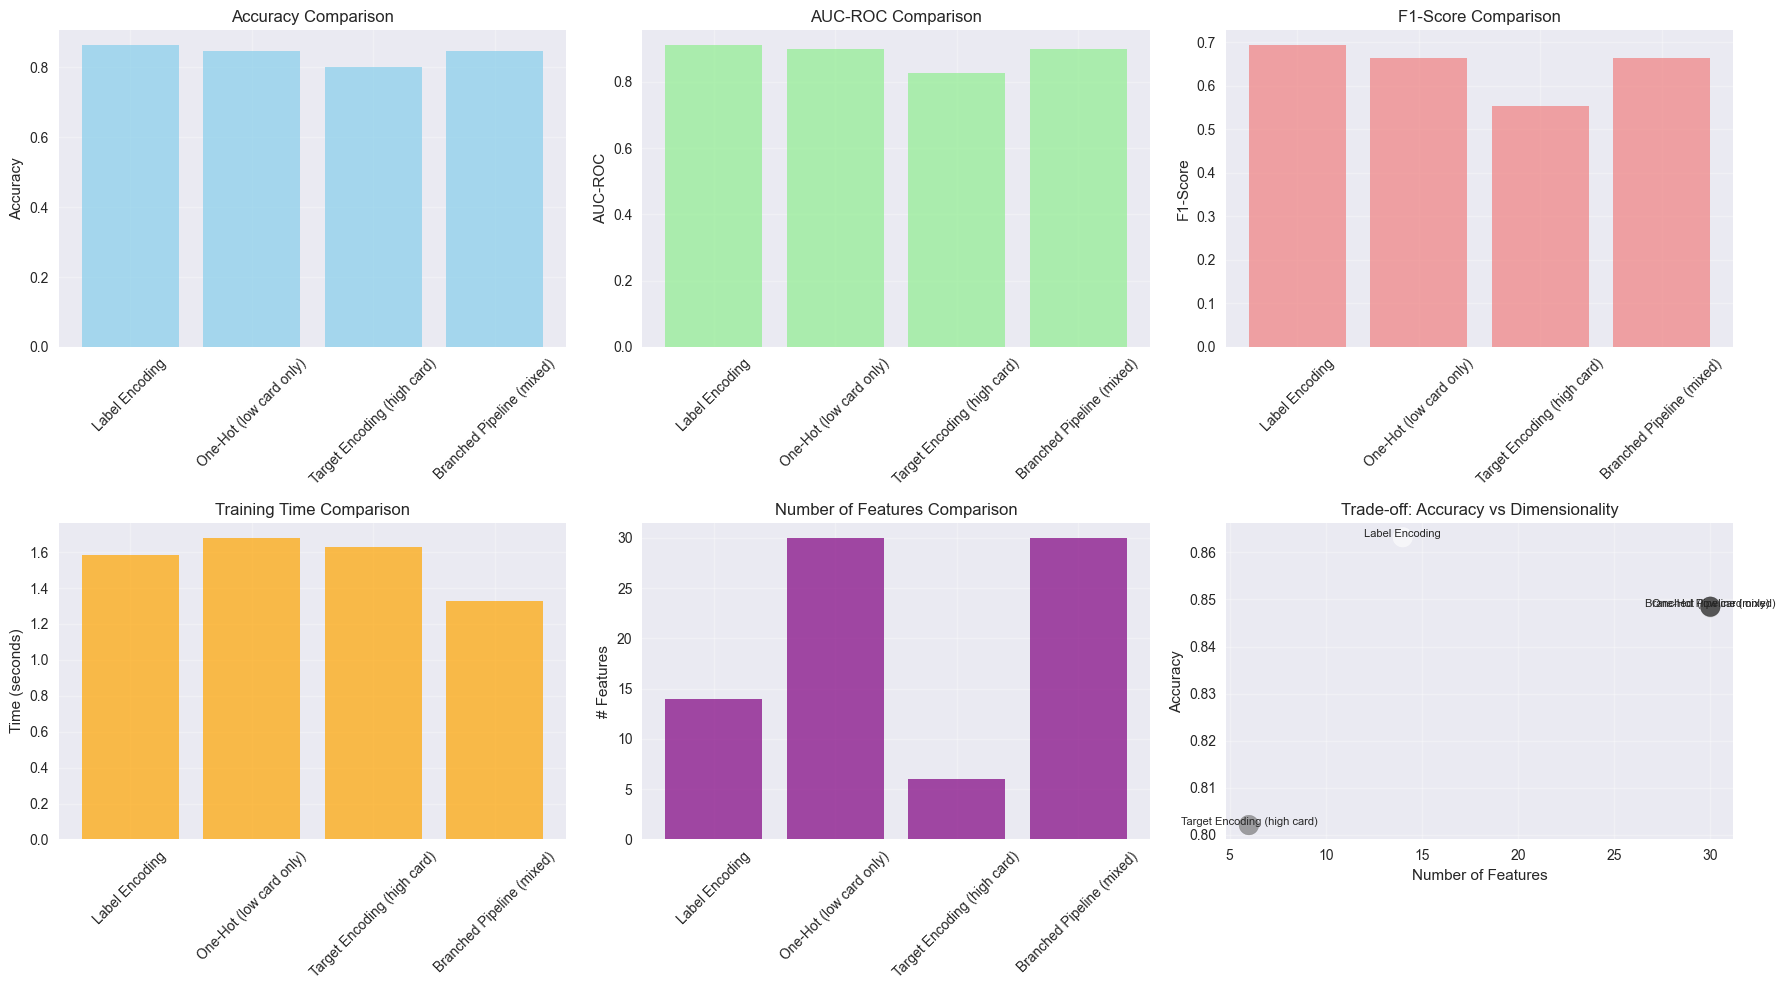


📊 ANÁLISIS DE TRADE-OFFS:
------------------------------------------------------------
🔍 Accuracy vs Dimensionalidad:
   Label Encoding: 0.8632 accuracy con 14 features
   Target Encoding: 0.8021 accuracy con 6 features

🔍 Accuracy vs Tiempo:
   Label Encoding: 0.8632 accuracy en 1.58s
   One-Hot (low card only): 0.8483 accuracy en 1.68s
   Target Encoding (high card): 0.8021 accuracy en 1.63s
   Branched Pipeline (mixed): 0.8485 accuracy en 1.33s

   ⭐ Mejor balance accuracy/tiempo: Branched Pipeline (mixed) (0.8485 accuracy, 1.33s)

🔍 Recomendación para Producción:
Elejiría Label Encoding porque es el que obtuvo las mejores métricas, y la diferencia de tiempo no es tan relevante


In [18]:
# === COMPARACIÓN DE TODOS LOS MÉTODOS ===

print("\n📊 COMPARACIÓN DE MÉTODOS DE ENCODING")
print("=" * 60)

# 1. Consolidar resultados
all_results = [
    results_label,
    results_onehot,
    results_target,
    results_pipeline
]

results_df = pd.DataFrame(all_results)

# 2. Mostrar tabla comparativa
print("\n🔝 TABLA COMPARATIVA:")
print(results_df.to_string(index=False))

# 3. Identificar mejor método por métrica
print("\n🏆 MEJORES MÉTODOS POR MÉTRICA:")
print(f"   🎯 Mejor Accuracy: {results_df.loc[results_df['accuracy'].idxmax(), 'encoding']} "
      f"({results_df['accuracy'].max():.4f})")
print(f"   🎯 Mejor AUC-ROC: {results_df.loc[results_df['auc'].idxmax(), 'encoding']} "
      f"({results_df['auc'].max():.4f})")
print(f"   🎯 Mejor F1-Score: {results_df.loc[results_df['f1_score'].idxmax(), 'encoding']} "
      f"({results_df['f1_score'].max():.4f})")
print(f"   ⚡ Más rápido: {results_df.loc[results_df['training_time'].idxmin(), 'encoding']} "
      f"({results_df['training_time'].min():.2f}s)")
print(f"   📏 Menos features: {results_df.loc[results_df['n_features'].idxmin(), 'encoding']} "
      f"({results_df['n_features'].min()} features)")

# 4. Visualización comparativa
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Accuracy
axes[0, 0].bar(results_df['encoding'], results_df['accuracy'], color='skyblue', alpha=0.7)
axes[0, 0].set_title('Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# AUC-ROC
axes[0, 1].bar(results_df['encoding'], results_df['auc'], color='lightgreen', alpha=0.7)
axes[0, 1].set_title('AUC-ROC Comparison')
axes[0, 1].set_ylabel('AUC-ROC')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# F1-Score
axes[0, 2].bar(results_df['encoding'], results_df['f1_score'], color='lightcoral', alpha=0.7)
axes[0, 2].set_title('F1-Score Comparison')
axes[0, 2].set_ylabel('F1-Score')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(True, alpha=0.3)

# Training Time
axes[1, 0].bar(results_df['encoding'], results_df['training_time'], color='orange', alpha=0.7)
axes[1, 0].set_title('Training Time Comparison')
axes[1, 0].set_ylabel('Time (seconds)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Number of Features
axes[1, 1].bar(results_df['encoding'], results_df['n_features'], color='purple', alpha=0.7)
axes[1, 1].set_title('Number of Features Comparison')
axes[1, 1].set_ylabel('# Features')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# Trade-off: Accuracy vs Features
axes[1, 2].scatter(results_df['n_features'], results_df['accuracy'], s=200, alpha=0.6, c=range(len(results_df)))
for i, txt in enumerate(results_df['encoding']):
    axes[1, 2].annotate(txt, (results_df.iloc[i]['n_features'], results_df.iloc[i]['accuracy']), 
                       fontsize=8, ha='center')
axes[1, 2].set_xlabel('Number of Features')
axes[1, 2].set_ylabel('Accuracy')
axes[1, 2].set_title('Trade-off: Accuracy vs Dimensionality')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Análisis de trade-offs
print("\n📊 ANÁLISIS DE TRADE-OFFS:")
print("-" * 60)

# TODO: Completa el análisis
print("🔍 Accuracy vs Dimensionalidad:")
print(f"   Label Encoding: {results_df[results_df['encoding']=='Label Encoding']['accuracy'].values[0]:.4f} accuracy "
      f"con {results_df[results_df['encoding']=='Label Encoding']['n_features'].values[0]} features")
print(f"   Target Encoding: {results_df[results_df['encoding']=='Target Encoding (high card)']['accuracy'].values[0]:.4f} accuracy "
      f"con {results_df[results_df['encoding']=='Target Encoding (high card)']['n_features'].values[0]} features")

print("\n🔍 Accuracy vs Tiempo:")
# TODO: Comparar qué método da mejor balance accuracy/tiempo
for idx, row in results_df.iterrows():
      print(f"   {row['encoding']}: {row['accuracy']:.4f} accuracy en {row['training_time']:.2f}s")

best_balance = results_df.iloc[(results_df['accuracy'] / results_df['training_time']).idxmax()]
print(f"\n   ⭐ Mejor balance accuracy/tiempo: {best_balance['encoding']} "
        f"({best_balance['accuracy']:.4f} accuracy, {best_balance['training_time']:.2f}s)")

print("\n🔍 Recomendación para Producción:")
# TODO: Basándote en los resultados, ¿qué método recomendarías y por qué?
print("Elejiría Label Encoding porque es el que obtuvo las mejores métricas, y la diferencia de tiempo no es tan relevante")

In [ ]:
# === INVESTIGACIÓN LIBRE: TÉCNICAS AVANZADAS ===

print("\n🧪 INVESTIGACIÓN LIBRE")
print("=" * 60)

# 🎯 DESAFÍO 1: Frequency Encoding
print("🎯 DESAFÍO 1: Frequency Encoding")
print("-" * 40)

# TODO: Implementa frequency encoding
# PISTA: Codificar cada categoría con su frecuencia de aparición

def frequency_encoding(df, column):
    """
    Codificar categorías por su frecuencia
    """
    freq = df[column].value_counts(normalize=True).to_dict()
    return df[column].map(freq)

# TODO: Aplica frequency encoding a 'city' y evalúa performance
df_freq = df.copy()
# Cambia 'city' por 'native-country' (columna existente en df)
df_freq['native_country_freq'] = frequency_encoding(df_freq, 'native-country')
# ¿Cómo se compara con target encoding?


print("💡 PREGUNTAS:")
print("- ¿Frequency encoding captura información predictiva?")
print("- ¿Tiene riesgo de data leakage?")
print("- ¿Cuándo usar frequency vs target encoding?")

# 🎯 DESAFÍO 2: Ordinal Encoding
print("\n🎯 DESAFÍO 2: Ordinal Encoding")
print("-" * 40)

# TODO: Implementa ordinal encoding para variables con orden natural
# PISTA: 'education' y 'satisfaction' tienen orden natural

from sklearn.preprocessing import OrdinalEncoder

education_order = ['High School', 'Bachelor', 'Master', 'PhD']
satisfaction_order = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

# TODO: Crea un encoder ordinal
ordinal_encoder = OrdinalEncoder(categories=[education_order, satisfaction_order])
# ¿Mejora el performance vs label encoding?
df_ordinal = df.copy()
df_ordinal['education_ord'] = ordinal_encoder.fit_transform(df_ordinal[['education', 'satisfaction']])[:, 0]
df_ordinal['satisfaction_ord'] = ordinal_encoder.fit_transform(df_ordinal[['education', 'satisfaction']])[:, 1]
df_ordinal[['education_ord', 'satisfaction_ord']] = ordinal_encoder.fit_transform(df_ordinal[['education', 'satisfaction']])
                  
print("🔍 Accuracy vs Dimensionalidad:")
print(f"   Label Encoding: {results_df[results_df['encoding']=='Label Encoding']['accuracy'].values[0]:.4f} accuracy "
    f"con {results_df[results_df['encoding']=='Label Encoding']['n_features'].values[0]} features")
print(f"   Target Encoding: {results_df[results_df['encoding']=='Target Encoding (high card)']['accuracy'].values[0]:.4f} accuracy "
    f"con {results_df[results_df['encoding']=='Target Encoding (high card)']['n_features'].values[0]} features")
if 'Ordinal Encoding' in results_df['encoding'].values:
    print(f"   Ordinal Encoding: {results_df[results_df['encoding']=='Ordinal Encoding']['accuracy'].values[0]:.4f} accuracy "
        f"con {results_df[results_df['encoding']=='Ordinal Encoding']['n_features'].values[0]} features")
else:
    print("   Ordinal Encoding: resultado no disponible en results_df")

print("💡 PREGUNTAS:")
print("- ¿Por qué preservar el orden natural es importante?")
print("- ¿Qué modelos se benefician más de ordinal encoding?")
print("- ¿Cómo manejar categorías con orden parcial?")

# 🎯 DESAFÍO 3: Leave-One-Out Encoding
print("\n🎯 DESAFÍO 3: Leave-One-Out Target Encoding")
print("-" * 40)

# TODO: Implementa leave-one-out encoding manualmente
# PISTA: Para cada registro, calcula el promedio del target excluyendo ese registro

def leave_one_out_encoding(X, y, column):
    """
    Leave-one-out target encoding
    """
    # Para cada registro, calcular promedio excluyendo ese registro
    global_mean = y.mean()

    # Calcular suma y conteo por categoría
    agg = pd.DataFrame({'sum': y, 'count': y}).groupby(X[column]).agg({
        'sum': 'sum',
        'count': 'count'
    })

    # TODO: Implementa la lógica de leave-one-out
    # Para cada registro i:
    # encoded_value_i = (suma_categoria - y_i) / (count_categoria - 1)

    pass

print("💡 PREGUNTAS:")
print("- ¿Por qué leave-one-out previene overfitting?")
print("- ¿Es más costoso computacionalmente?")
print("- ¿Cuándo usar LOO vs cross-validation?")

# 🎯 DESAFÍO 4: Binary Encoding
print("\n🎯 DESAFÍO 4: Binary Encoding")
print("-" * 40)

# TODO: Explora binary encoding de category_encoders
# PISTA: Convierte entero a binario y descompone en bits

from category_encoders import BinaryEncoder

# TODO: Aplica binary encoding a 'city' (alta cardinalidad)
# binary_encoder = BinaryEncoder(cols=['city'])
# ¿Cuántas columnas crea? (log2(n_categories))
# ¿Cómo se compara con one-hot y target?

print("💡 PREGUNTAS:")
print("- ¿Por qué binary encoding reduce dimensionalidad?")
print("- ¿Cuántas columnas crea para N categorías?")
print("- ¿En qué escenarios es útil binary encoding?")

# 🎯 DESAFÍO 5: Smoothing en Target Encoding
print("\n🎯 DESAFÍO 5: Experimentar con Smoothing")
print("-" * 40)

# TODO: Prueba diferentes valores de smoothing (1, 10, 100, 1000)
# ¿Cómo afecta el smoothing al performance?

smoothing_values = [1, 10, 100, 1000]

print("💡 PREGUNTAS:")
print("- ¿Qué hace el parámetro smoothing?")
print("- ¿Cuándo usar smoothing alto vs bajo?")
print("- ¿Cómo afecta a categorías raras?")


🧪 INVESTIGACIÓN LIBRE
🎯 DESAFÍO 1: Frequency Encoding
----------------------------------------
💡 PREGUNTAS:
- ¿Frequency encoding captura información predictiva?
- ¿Tiene riesgo de data leakage?
- ¿Cuándo usar frequency vs target encoding?

🎯 DESAFÍO 2: Ordinal Encoding
----------------------------------------


KeyError: "['satisfaction'] not in index"